# Null text inversion

Null text inversion essentially involves 'inverting' a real image into latent space. This way, we have intermediates which are more amenable to editing. In the context of DragonDiffusion, if we are beginning with a real image, then we will use this technique to 'reconstruct' the image iteratively from the latent representation. Then, we'll use the features of the reconstructed version to guide the editing process. This is what gives us access to the attention matrices that are key to maintaining high consistency between original and edited images.

In [ ]:
#| export
from __future__ import annotations
import math, random, torch, matplotlib.pyplot as plt, numpy as np, matplotlib as mpl, shutil, os, gzip, pickle, re, copy
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
from functools import partial
import fastcore.all as fc
from glob import glob

from torch import tensor, nn, optim
import torch.nn.functional as F
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from diffusers import UNet2DModel
from torch.utils.data import DataLoader, default_collate
from torch.nn import init

from einops import rearrange
from fastprogress import progress_bar
from PIL import Image
from torchvision.io import read_image,ImageReadMode
from torchvision import transforms

from dataclasses import dataclass
from diffusers import DDIMScheduler
from diffusers.utils import BaseOutput

from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.utils import BaseOutput, deprecate
from diffusers.schedulers.scheduling_utils import SchedulerMixin

from dragon_diffusion.core import *
from dragon_diffusion.masks import *

The code below is taken from [this repo](https://github.com/thepowerfuldeez/null-text-inversion/blob/main/null_text_inversion.ipynb). I removed some redundant stuff to make it cleaner, otherwise it's the same.

In [ ]:
#| export
@dataclass
class DDIMSchedulerOutput(BaseOutput):
    """
    Output class for the scheduler's step function output.

    Args:
        prev_sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)` for images):
            Computed sample (x_{t-1}) of previous timestep. `prev_sample` should be used as next model input in the
            denoising loop.
        next_sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)` for images):
            Computed sample (x_{t+1}) of previous timestep. `next_sample` should be used as next model input in the
            reverse denoising loop.
        pred_original_sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)` for images):
            The predicted denoised sample (x_{0}) based on the model output from the current timestep.
            `pred_original_sample` can be used to preview progress or for guidance.
    """

    prev_sample: Optional[torch.FloatTensor] = None
    next_sample: Optional[torch.FloatTensor] = None
    pred_original_sample: Optional[torch.FloatTensor] = None

In [ ]:
#| export
def betas_for_alpha_bar(num_diffusion_timesteps, max_beta=0.999) -> torch.Tensor:
    """
    Create a beta schedule that discretizes the given alpha_t_bar function, which defines the cumulative product of
    (1-beta) over time from t = [0,1].

    Contains a function alpha_bar that takes an argument t and transforms it to the cumulative product of (1-beta) up
    to that part of the diffusion process.


    Args:
        num_diffusion_timesteps (`int`): the number of betas to produce.
        max_beta (`float`): the maximum beta to use; use values lower than 1 to
                     prevent singularities.

    Returns:
        betas (`np.ndarray`): the betas used by the scheduler to step the model outputs
    """

    def alpha_bar(time_step):
        return math.cos((time_step + 0.008) / 1.008 * math.pi / 2) ** 2

    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.tensor(betas)

In [ ]:
#| export
class DDIMSched(DDIMScheduler):
    def reverse_step(
        self,
        model_output: torch.FloatTensor,
        timestep: int,
        sample: torch.FloatTensor,
        eta: float = 0.0,
        use_clipped_model_output: bool = False,
        generator=None,
        return_dict: bool = True,
    ) -> Union[DDIMSchedulerOutput, Tuple]:
        """
        Predict the sample at the previous timestep by reversing the SDE. Core function to propagate the diffusion
        process from the learned model outputs (most often the predicted noise).

        Args:
            model_output (`torch.FloatTensor`): direct output from learned diffusion model.
            timestep (`int`): current discrete timestep in the diffusion chain.
            sample (`torch.FloatTensor`):
                current instance of sample being created by diffusion process.
            eta (`float`): weight of noise for added noise in diffusion step.
            use_clipped_model_output (`bool`): TODO
            generator: random number generator.
            return_dict (`bool`): option for returning tuple rather than DDIMSchedulerOutput class

        Returns:
            [`~schedulers.scheduling_utils.DDIMSchedulerOutput`] or `tuple`:
            [`~schedulers.scheduling_utils.DDIMSchedulerOutput`] if `return_dict` is True, otherwise a `tuple`. When
            returning a tuple, the first element is the sample tensor.

        """
        if self.num_inference_steps is None:
            raise ValueError(
                "Number of inference steps is 'None', you need to run 'set_timesteps' after creating the scheduler"
            )

        # See formulas (12) and (16) of DDIM paper https://arxiv.org/pdf/2010.02502.pdf
        # Ideally, read DDIM paper in-detail understanding

        # Notation (<variable name> -> <name in paper>
        # - pred_noise_t -> e_theta(x_t, t)
        # - pred_original_sample -> f_theta(x_t, t) or x_0
        # - std_dev_t -> sigma_t
        # - eta -> η
        # - pred_sample_direction -> "direction pointing to x_t"
        # - pred_prev_sample -> "x_t-1"

        # 1. get previous step value (=t-1)
        next_timestep = min(self.config.num_train_timesteps - 2,
                            timestep + self.config.num_train_timesteps // self.num_inference_steps)

        # 2. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_next = self.alphas_cumprod[next_timestep] if next_timestep >= 0 else self.final_alpha_cumprod

        beta_prod_t = 1 - alpha_prod_t

        # 3. compute predicted original sample from predicted noise also called
        # "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)

        # 4. Clip "predicted x_0"
        if self.config.clip_sample:
            pred_original_sample = torch.clamp(pred_original_sample, -1, 1)

        # 5. TODO: simple noising implementatiom
        next_sample = self.add_noise(pred_original_sample,
                                     model_output,
                                     torch.LongTensor([next_timestep]))

        # # 5. compute variance: "sigma_t(η)" -> see formula (16)
        # # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
        # variance = self._get_variance(next_timestep, timestep)
        # std_dev_t = eta * variance ** (0.5)

        # if use_clipped_model_output:
        #     # the model_output is always re-derived from the clipped x_0 in Glide
        #     model_output = (sample - alpha_prod_t ** (0.5) * pred_original_sample) / beta_prod_t ** (0.5)

        # # 6. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        # pred_sample_direction = (1 - alpha_prod_t_next - std_dev_t**2) ** (0.5) * model_output

        # # 7. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        # next_sample = alpha_prod_t_next ** (0.5) * pred_original_sample + pred_sample_direction

        if not return_dict:
            return (next_sample,)

        return DDIMSchedulerOutput(next_sample=next_sample, pred_original_sample=pred_original_sample)

    def add_noise(
        self,
        original_samples: torch.FloatTensor,
        noise: torch.FloatTensor,
        timesteps: torch.IntTensor,
    ) -> torch.FloatTensor:
        if self.alphas_cumprod.device != original_samples.device:
            self.alphas_cumprod = self.alphas_cumprod.to(original_samples.device)
        if timesteps.device != original_samples.device:
            timesteps = timesteps.to(original_samples.device)

        sqrt_alpha_prod = self.alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - self.alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        return noisy_samples

    def __len__(self):
        return self.config.num_train_timesteps

In [ ]:
from diffusers import LMSDiscreteScheduler, UNet2DConditionModel, AutoencoderKL
from transformers import AutoTokenizer, CLIPTextModel

In [ ]:
model = UNet2DConditionModel.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='unet').cuda()
tokenizer = AutoTokenizer.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='tokenizer')
text_encoder = CLIPTextModel.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='text_encoder')
vae = AutoencoderKL.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='vae').to('cuda')

In [ ]:
scheduler = DDIMSched(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')

In [ ]:
prompt = 'an astronaut floating in space'
uncond_embeddings = get_embeddings("", text_encoder, tokenizer, concat_unconditional=False, device='cuda')
cond_embeddings = get_embeddings(prompt, text_encoder, tokenizer, concat_unconditional=False, device='cuda')

In [ ]:
def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    return torch.from_numpy(image)

In [ ]:
def load_img(file_path, height, width, return_tensor=False, device='cpu'):
    image = Image.open(file_path).resize((height, width))
    if return_tensor: return transforms.ToTensor()(image).to(device)
    return image

In [ ]:
def encode_img(file_path, height, width, vae, device='cuda', concat=None):
    img = load_img(file_path, height, width)
    img = preprocess(img)
    if concat: im_tensor = torch.cat([im_tensor]*concat, dim=1)
    latents = vae.encode(img.to(vae.device) * 2 - 1).latent_dist.sample()
    return latents * 0.18215

In [ ]:
img_path = '/home/astronaut.jpg'
height, width = 512, 512
latents = encode_img(img_path, height, width, vae) ## start from existing image
scheduler.set_timesteps(50)
device = 'cuda'
torch.manual_seed(42)

# flip the timesteps vector 
timesteps = scheduler.timesteps.flip(0)

# storage object for the latent trajectory
latent_trajectory = torch.zeros(len(scheduler.timesteps), 4, height//8, width//8)

with torch.no_grad():
    for i, t in enumerate(progress_bar(timesteps, leave=False, comment="inverting image...")):
        # encode the image into latent space and store the intermediates in latent_trajectory
        latent_trajectory[i] = latents
        latent_model_input = latents.to(device)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        noise_pred = model(latent_model_input, t, encoder_hidden_states=cond_embeddings).sample
        latents = scheduler.reverse_step(noise_pred, t, latents).next_sample
        # latents is now the last latent z_T, a noised version of input image
        # the full latent trajectory is now in latent_trajectory in reverse order

In [ ]:
ims = []
for i, image in enumerate(latent_trajectory):
    if i % 10 == 0:
        print(image.shape)
        image = vae.decode(image.to(vae.device).unsqueeze(0)).sample
        ims.append(image)

torch.Size([4, 64, 64])
torch.Size([4, 64, 64])
torch.Size([4, 64, 64])
torch.Size([4, 64, 64])
torch.Size([4, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


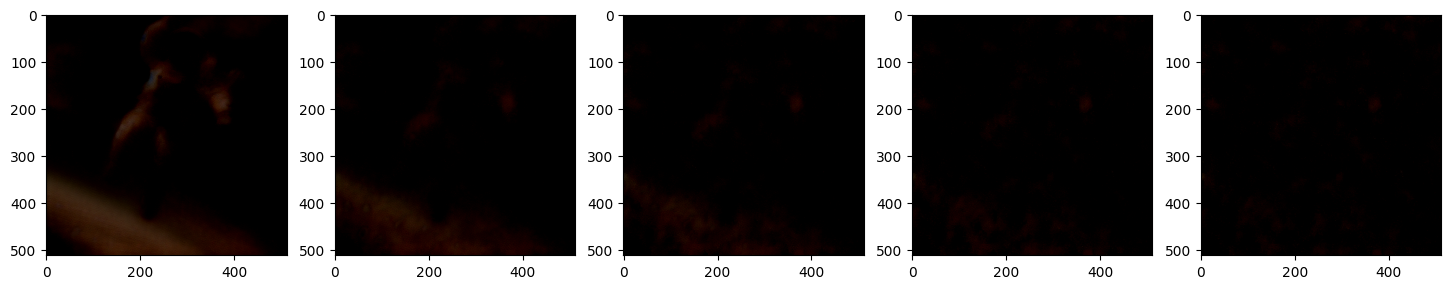

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(18, 12))
for i in range(len(ims)):
    ax[i].imshow(ims[i][0].cpu().detach().permute(1,2,0).numpy())